# Projet 9 - Entrainements des architectures SegFormer (B0, B1, B2)

## 📋 Vue d'ensemble

Ce notebook implémente l'entraînement complet des modèles SegFormer (B0, B1, B2) pour la segmentation sémantique sur Cityscapes. L'approche utilise les modèles pré-entraînés de NVIDIA avec adaptation fine aux 8 classes du projet.

### 🎯 Objectifs
- Entraîner 3 variantes SegFormer avec complexité croissante
- Comparer les performances vs baseline VGG16-UNet (IoU=0.631)  
- Optimiser pour déploiement Azure F1 (<100MB, 1GB RAM)
- Documenter les résultats pour la preuve de concept P9

In [ ]:
📋 CHECKLIST D'EXÉCUTION
=======================

## CYCLE 1 - Modèle B2 (le plus lourd)
□ 1. Ouvrir le notebook frais
□ 2. Exécuter cellules 1 à 7 (setup)
□ 3. Exécuter cellule 8.0 (arrêt auto)
□ 4. Kernel > Restart
□ 5. Ré-exécuter cellules 1 à 7
□ 6. Exécuter UNIQUEMENT cellule 8.1 (B2)
□ 7. Attendre fin (~2h)
□ 8. Exécuter cellule 8.2 (arrêt après B2)
□ 9. Vérifier result_b2.pkl créé ✓

## CYCLE 2 - Modèle B1 (intermédiaire)
□ 1. Kernel > Restart & Clear Output
□ 2. Exécuter cellules 1 à 7
□ 3. Exécuter cellule 8.0 (arrêt auto)
□ 4. Kernel > Restart
□ 5. Ré-exécuter cellules 1 à 7
□ 6. Exécuter UNIQUEMENT cellule 8.3 (B1)
□ 7. Attendre fin (~1.5h)
□ 8. Exécuter cellule 8.4 (arrêt après B1)
□ 9. Vérifier result_b1.pkl créé ✓

## CYCLE 3 - Modèle B0 (le plus léger)
□ 1. Kernel > Restart & Clear Output
□ 2. Exécuter cellules 1 à 7
□ 3. Exécuter cellule 8.0 (arrêt auto)
□ 4. Kernel > Restart
□ 5. Ré-exécuter cellules 1 à 7
□ 6. Exécuter UNIQUEMENT cellule 8.5 (B0)
□ 7. Attendre fin (~2h)
□ 8. Vérifier result_b0.pkl créé ✓
□ 9. Vérifier all_results.pkl créé ✓

## FINAL - Analyse des résultats
□ 1. Kernel > Restart & Clear Output
□ 2. Exécuter cellules 1 à 7
□ 3. Exécuter cellule 8.6 (Résumé)
□ 4. Exécuter cellule 9 (Analyse comparative)

### 1. Imports et configuration

### 📦 Dépendances critiques
- **transformers** 4.44+ : Framework Hugging Face pour SegFormer
- **torch** 2.0+ : Backend PyTorch avec support CUDA 11.8
- **mlflow** : Tracking des expériences et métriques
- **evaluate** : Calcul des métriques IoU officielles

In [1]:
# 1. Imports et configuration initiale
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Suppression des warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Configuration GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Imports standards
import numpy as np
import pandas as pd
from pathlib import Path
import time
from typing import Dict, List, Optional, Tuple

# Deep Learning
import torch
from torch.utils.data import Dataset, DataLoader

# Transformers
import transformers
from transformers import (
    SegformerForSemanticSegmentation,
    SegformerFeatureExtractor,
    SegformerImageProcessor,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from transformers.trainer_callback import TrainerCallback

from scipy.ndimage import zoom

# MLflow
import mlflow
import mlflow.pytorch

import gc

# Configuration du projet
project_root = Path.cwd().parent
sys.path.append(str(project_root))

print(f"📁 Racine du projet : {project_root}")
print(f"🐍 Python : {sys.version.split()[0]}")
print(f"🔥 PyTorch : {torch.__version__}")
print(f"🤗 Transformers : {transformers.__version__}")
print(f"📊 MLflow : {mlflow.__version__}")

# Vérification GPU
if torch.cuda.is_available():
    print(f"🎮 GPU : {torch.cuda.get_device_name(0)}")
    print(f"   Mémoire : {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("💻 Mode CPU (pas de GPU détecté)")

📁 Racine du projet : /home/didier/Documents/OpenClassrooms/Projet9/pour_github
🐍 Python : 3.10.18
🔥 PyTorch : 2.7.1+cu126
🤗 Transformers : 4.36.0
📊 MLflow : 3.1.4
🎮 GPU : NVIDIA GeForce RTX 3090
   Mémoire : 23.6 GB


In [2]:
# Cellule de diagnostic
import transformers

print("Diagnostic des backends :")
print(f"- PyTorch disponible dans transformers : {transformers.is_torch_available()}")
print(f"- TensorFlow disponible dans transformers : {transformers.is_tf_available()}")
print(f"- Flax disponible dans transformers : {transformers.is_flax_available()}")

if not transformers.is_torch_available():
    print("\n⚠️ ATTENTION : PyTorch n'est pas détecté par Transformers !")
    print("Solutions possibles :")
    print("1. Réinstaller transformers : pip install transformers[torch]")
    print("2. Vérifier l'installation de PyTorch : pip install torch torchvision")

Diagnostic des backends :
- PyTorch disponible dans transformers : True
- TensorFlow disponible dans transformers : True
- Flax disponible dans transformers : False


### 2. Configuration générale

### 📦 Dépendances critiques
- **transformers** 4.44+ : Framework Hugging Face pour SegFormer
- **torch** 2.0+ : Backend PyTorch avec support CUDA 11.8
- **mlflow** : Tracking des expériences et métriques
- **evaluate** : Calcul des métriques IoU officielles

In [3]:
# 2. Configuration générale
VERSION_P9 = 19

class Config:
    """Configuration globale du projet"""
    # Dimensions
    IMG_HEIGHT = 256
    IMG_WIDTH = 512
    NUM_CLASSES = 8
    
    # Entraînement
    BATCH_SIZE = 8
    EPOCHS_SEGFORMER = 40 # pour debug 40
    LEARNING_RATE_SEGFORMER = 1e-4
    
    # Chemins
    DATA_DIR = Path('../data')
    MODELS_DIR = Path(f'../models/SegFormer_comparison_v{VERSION_P9}')
    MODELS_DIR.mkdir(parents=True, exist_ok=True)
    
    RESULTS_DIR = Path(f'../results/project9/SegFormer_comparison_v{VERSION_P9}')
    RESULTS_DIR.mkdir(parents=True, exist_ok=True)
    
    # Classes Cityscapes
    CITYSCAPES_CLASSES = ['flat', 'human', 'vehicle', 'construction', 
                          'object', 'nature', 'sky', 'void']
    
    # Poids des classes (du P8)
    # CLASS_WEIGHTS = [0.396, 0.021, 0.148, 0.197, 0.022, 0.118, 0.062, 0.036]
    CLASS_WEIGHTS = [0.50, 3.16, 0.63, 0.50, 1.82, 0.50, 1.17, 0.54]
    # MLflow
    MLFLOW_URI = "../mlruns"
    EXPERIMENT_NAME = f"P9_SegFormer_Comparison_v{VERSION_P9}"

    # ... autres configs ...
    DEBUG_MODE = True  # Mettre à False en production
    CLEAN_CHECKPOINTS = True  # Pour nettoyer en debug²  

# Configuration MLflow
mlflow.set_tracking_uri(f"file:///{project_root}/mlruns")
mlflow.set_experiment(Config.EXPERIMENT_NAME)

print(f"\n✅ Configuration chargée (version {VERSION_P9})")
print(f"📊 Expérience MLflow : {Config.EXPERIMENT_NAME}")


✅ Configuration chargée (version 19)
📊 Expérience MLflow : P9_SegFormer_Comparison_v19


> ✅ Configuration initialisée. Batch size=8, 40 epochs, learning rate=1e-4.
> Poids de classes balancés selon distribution Cityscapes : [0.50, 3.16, 0.63, 0.50, 1.82, 0.50, 1.17, 0.54].
> Répertoires models/ et results/ créés.

### 3. Configuration des modèles SegFormer

### 🏗️ Architecture SegFormer
Famille de Vision Transformers hiérarchiques avec encodeur multi-échelle et décodeur MLP léger. Les variantes B0→B2 offrent un trade-off progressif entre efficacité et performance.

In [4]:
# 3. Configuration des modèles SegFormer
class SegFormerConfigs:
    """Configurations pour les différentes variantes de SegFormer"""
    
    # Configurations communes
    USE_MIXED_PRECISION = True
    GRADIENT_CHECKPOINTING = False
    GRADIENT_ACCUMULATION_STEPS = 2
    SAVE_STEPS = 250
    EVAL_STEPS = 250
    
    # Modèles disponibles
    MODELS = {
        'B0': {
            'name': 'nvidia/segformer-b0-finetuned-cityscapes-1024-1024',
            'description': 'SegFormer B0 - Le plus léger (3.7M params)',
            'expected_size_mb': 15,
            'expected_iou': 0.65,
            # Hyperparamètres spécifiques
            'learning_rate': 2e-5,
            'gradient_accumulation_steps': 1,
            'fp16': True,
            'warmup_ratio': 0.1,
            'max_grad_norm': 1.0,
            'gradient_checkpointing': False,
            'tf32': True, 
        },
        'B1': {
            'name': 'nvidia/segformer-b1-finetuned-cityscapes-1024-1024',
            'description': 'SegFormer B1 - Intermédiaire (13.7M params)',
            'expected_size_mb': 55,
            'expected_iou': 0.68,
            # Hyperparamètres spécifiques
            'learning_rate': 2e-5,  # 1.5e-4,
            'gradient_accumulation_steps': 2,
            'fp16': True,
            'warmup_ratio': 0.15,
            'max_grad_norm': 1.0,
            'gradient_checkpointing': False,  # Par défaut
            'tf32': True,  # Par défaut
        },
        'B2': {
            'name': 'nvidia/segformer-b2-finetuned-cityscapes-1024-1024',
            'description': 'SegFormer B2 - Le plus performant (25.5M params)',
            'expected_size_mb': 104,
            'expected_iou': 0.70,
            # Hyperparamètres spécifiques
            'learning_rate': 1e-4,    # 5e-5,
            'gradient_accumulation_steps': 2,
            'fp16': True,
            'warmup_ratio': 0.2,
            'max_grad_norm': 1.0,
            'gradient_checkpointing': False,  # Par défaut
            'tf32': True,  # Par défaut
        }
    }
    @classmethod
    def get_model_config(cls, model_type: str) -> dict:
        """Récupère la configuration d'un modèle spécifique"""
        if model_type not in cls.MODELS:
            raise ValueError(f"Modèle {model_type} non supporté. Choisir parmi : {list(cls.MODELS.keys())}")
        return cls.MODELS[model_type]

# Affichage des modèles disponibles
print("\n📋 Modèles SegFormer disponibles :")
for model_type, config in SegFormerConfigs.MODELS.items():
    print(f"   - {model_type}: {config['description']}")


📋 Modèles SegFormer disponibles :
   - B0: SegFormer B0 - Le plus léger (3.7M params)
   - B1: SegFormer B1 - Intermédiaire (13.7M params)
   - B2: SegFormer B2 - Le plus performant (25.5M params)


> 📊 3 modèles configurés : B0 (3.7M params, ~15MB attendu), B1 (13.7M params, ~55MB attendu), B2 (25.5M params, ~104MB attendu).
> 
> Learning rates différenciés : B0=2e-5, B1=2e-5, B2=1e-4. Gradient accumulation : B0=1, B1=2, B2=2.

### 4. Dataset et générateur de données

### 🗂️ Pipeline de données Cityscapes
Adaptation du générateur P8 pour compatibilité Hugging Face. Utilise SegformerImageProcessor pour preprocessing standardisé (normalisation ImageNet, resize 256x512).

In [5]:
# 4. Dataset et générateur de données
from PIL import Image
import numpy as np

class CityscapesDatasetPyTorch(Dataset):
    """
    Dataset PyTorch pour SegFormer
    Adapté du data_generator.py du P8
    """
    def __init__(self, data_dir, split='train', feature_extractor=None):
        self.data_dir = Path(data_dir)
        self.split = split
        self.feature_extractor = feature_extractor
        
        # Chargement des chemins - UTILISER LA MÊME APPROCHE QUE test14c.ipynb
        self.image_paths = list((self.data_dir / f'raw/leftImg8bit/{split}').rglob('*_leftImg8bit.png'))
        self.mask_paths = [self._get_mask_path(img_path) for img_path in self.image_paths]
        
        # Mapping des labels (34 -> 8 classes)
        self.label_mapping = self._create_label_mapping()
        
        print(f"Dataset {split} : {len(self.image_paths)} images")
    
    def _get_mask_path(self, image_path):
        """Obtient le chemin du masque correspondant"""
        # Extraire le nom de base (sans _leftImg8bit.png)
        base_name = str(image_path.name).replace('_leftImg8bit.png', '')
        
        # Construire le nom du masque
        mask_name = base_name + '_gtFine_labelIds.png'
        
        # Construire le chemin complet
        mask_dir = str(image_path.parent).replace('leftImg8bit', 'gtFine')
        mask_path = Path(mask_dir) / mask_name
        
        return mask_path
    
    def _create_label_mapping(self):
        """Crée le mapping 34 -> 8 classes"""
        mapping = np.zeros(256, dtype=np.uint8)
        
        # Mapping identique au P8
        class_mappings = {
            0: [7, 8, 9, 10],      # flat
            1: [24, 25],           # human
            2: [26, 27, 28, 29, 30, 31, 32, 33],  # vehicle
            3: [11, 12, 13, 14, 15, 16],          # construction
            4: [17, 18, 19, 20],   # object
            5: [21, 22],           # nature
            6: [23],               # sky
            7: [0, 1, 2, 3, 4, 5, 6, 255]  # void/unlabeled
        }
        
        for new_class, old_classes in class_mappings.items():
            for old_class in old_classes:
                if old_class >= 0:
                    mapping[old_class] = new_class
        
        return mapping
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Charger image et masque
        image = Image.open(self.image_paths[idx]).convert('RGB')
        mask = np.array(Image.open(self.mask_paths[idx]))
        
        # Appliquer le mapping 34 -> 8 classes
        mask = self.label_mapping[mask]
        
        # Convertir le masque numpy en PIL Image
        mask = Image.fromarray(mask.astype(np.uint8))
        
        # Préprocessing avec feature_extractor
        if self.feature_extractor is not None:
            encoding = self.feature_extractor(
                images=image,
                segmentation_maps=mask,
                return_tensors="pt"
            )
            
            # Retirer la dimension batch ajoutée par return_tensors="pt"
            for key, value in encoding.items():
                encoding[key] = value.squeeze(0)
            
            return encoding
        
        return {"image": image, "mask": mask}

print("✅ Dataset PyTorch configuré")

✅ Dataset PyTorch configuré


In [6]:
# Diagnostic des chemins de données
data_dir = Path('../data')
print(f"🔍 Vérification des données dans : {data_dir}")

# Vérifier la structure Cityscapes
cityscapes_paths = {
    'train_images': data_dir / 'raw/leftImg8bit/train',
    'train_masks': data_dir / 'raw/gtFine/train',
    'val_images': data_dir / 'raw/leftImg8bit/val',
    'val_masks': data_dir / 'raw/gtFine/val'
}

for name, path in cityscapes_paths.items():
    if path.exists():
        # Compter les fichiers PNG
        png_files = list(path.rglob('*.png'))
        print(f"✅ {name}: {path} ({len(png_files)} fichiers)")
    else:
        print(f"❌ {name}: {path} NON TROUVÉ")

# Exemple de fichiers trouvés
if (data_dir / 'raw/leftImg8bit/train').exists():
    example_files = list((data_dir / 'raw/leftImg8bit/train').rglob('*_leftImg8bit.png'))[:3]
    print(f"\n📄 Exemples de fichiers trouvés :")
    for f in example_files:
        print(f"   - {f.relative_to(data_dir)}")

🔍 Vérification des données dans : ../data
✅ train_images: ../data/raw/leftImg8bit/train (2975 fichiers)
✅ train_masks: ../data/raw/gtFine/train (8925 fichiers)
✅ val_images: ../data/raw/leftImg8bit/val (500 fichiers)
✅ val_masks: ../data/raw/gtFine/val (1500 fichiers)

📄 Exemples de fichiers trouvés :
   - raw/leftImg8bit/train/tubingen/tubingen_000013_000019_leftImg8bit.png
   - raw/leftImg8bit/train/tubingen/tubingen_000123_000019_leftImg8bit.png
   - raw/leftImg8bit/train/tubingen/tubingen_000028_000019_leftImg8bit.png


### 5. Métriques et callbacks

### 📏 Évaluation multi-métrique
Implémentation des métriques cohérentes avec P8 pour comparaison directe. Calcul IoU par classe + IoU pondéré selon importance métier. Intégration early stopping intelligent pour éviter overfitting.

In [7]:
# 5. Métriques et callbacks

from transformers import EarlyStoppingCallback
from transformers.trainer_callback import TrainerCallback

def compute_metrics_p8_style(eval_pred):
    """
    Calcule les métriques exactement comme dans P8
    pour assurer la cohérence
    """
    predictions, labels = eval_pred
    
    # S'assurer que tout est en numpy
    if hasattr(predictions, 'cpu'):
        predictions = predictions.cpu().numpy()
    if hasattr(labels, 'cpu'):
        labels = labels.cpu().numpy()
    
    # Redimensionner si nécessaire
    if predictions.shape[2:] != labels.shape[1:]:
        # Utiliser scipy ou cv2 pour le resize
        from scipy.ndimage import zoom
        h, w = labels.shape[1:3]
        zoom_factors = (1, 1, h/predictions.shape[2], w/predictions.shape[3])
        predictions = zoom(predictions, zoom_factors, order=1)
    
    # Obtenir les classes
    pred_classes = np.argmax(predictions, axis=1)
    
    # Calculer la confusion matrix globale
    confusion_matrix = np.zeros((Config.NUM_CLASSES, Config.NUM_CLASSES))
    
    for i in range(pred_classes.shape[0]):
        pred_flat = pred_classes[i].flatten()
        label_flat = labels[i].flatten()
        
        # Exactement comme P8
        for true_idx in range(len(label_flat)):
            true_class = label_flat[true_idx]
            pred_class = pred_flat[true_idx]
            if 0 <= true_class < Config.NUM_CLASSES and 0 <= pred_class < Config.NUM_CLASSES:
                confusion_matrix[true_class, pred_class] += 1
    
    # Calcul IoU identique à P8
    iou_per_class = []
    for i in range(Config.NUM_CLASSES):
        intersection = confusion_matrix[i, i]
        union = confusion_matrix[i, :].sum() + confusion_matrix[:, i].sum() - intersection
        
        if union > 0:
            iou = intersection / union
        else:
            iou = 0.0
        iou_per_class.append(iou)
    
    # Résultats
    # Normaliser les poids pour que leur somme = 1
    weights = np.array(Config.CLASS_WEIGHTS)
    weights_normalized = weights / weights.sum()
    
    # Résultats avec IoU pondéré
    mean_iou = np.mean(iou_per_class)
    weighted_iou = float(np.sum(np.array(iou_per_class) * weights_normalized))
    
    results = {
        "mean_iou": mean_iou,
        "weighted_iou": weighted_iou,
    }
    
    for i, class_name in enumerate(Config.CITYSCAPES_CLASSES):
        results[f"iou_{class_name}"] = iou_per_class[i]
    
    return results

class EarlyStoppingMessageCallback(TrainerCallback):
    """Callback pour afficher un message lors de l'early stopping"""
    def on_train_end(self, args, state, control, **kwargs):
        # Vérifier si c'était vraiment un early stopping
        if state.best_metric is not None and state.epoch < args.num_train_epochs:
            print(f"\n🛑 Early Stopping déclenché à l'époque {state.epoch:.0f}/{args.num_train_epochs}")
            print(f"   Meilleur score atteint à l'époque {state.best_model_checkpoint.split('-')[-1]}")
        else:
            print(f"\n✅ Entraînement terminé normalement ({state.epoch:.0f} époques)")

print("✅ Métriques et callbacks configurés")

✅ Métriques et callbacks configurés


> ✅ Métriques P8-compatibles configurées. Early stopping configuré avec patience=5 epochs, threshold=0.0005. Callback personnalisé pour monitoring.

### 6. Trainer personnalisé avec loss pondérée

### ⚖️ Loss pondérée par classe
Extension du Trainer Hugging Face pour intégrer les poids de classes Cityscapes. Compensation du déséquilibre des classes (route/ciel majoritaires vs piétons/cyclistes minoritaires).

In [8]:
# 6. Trainer personnalisé avec loss pondérée (VERSION CORRIGÉE)

class WeightedSegformerTrainer(Trainer):
    """
    Trainer personnalisé qui reçoit les poids de classe à l'initialisation
    pour éviter les problèmes d'état global.
    """
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        # On stocke les poids convertis en tenseur UNE SEULE FOIS
        if class_weights is not None:
            # S'assurer que les poids sont sur le bon device (GPU/CPU)
            device = self.args.device
            self.class_weights_tensor = torch.tensor(class_weights, device=device, dtype=torch.float32)
        else:
            self.class_weights_tensor = None

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Upsampler les logits à la taille des labels
        import torch.nn.functional as F
        upsampled_logits = F.interpolate(
            logits, 
            size=labels.shape[-2:],
            mode="bilinear", 
            align_corners=False
        )
        
        # Utiliser le tenseur de poids stocké au lieu de le recréer
        loss = F.cross_entropy(
            upsampled_logits, 
            labels, 
            weight=self.class_weights_tensor, # Utilise l'attribut de la classe
            ignore_index=255
        )
        
        return (loss, outputs) if return_outputs else loss

print("✅ Trainer personnalisé (version corrigée) avec loss pondérée défini")

✅ Trainer personnalisé (version corrigée) avec loss pondérée défini


> ✅ Trainer avec CrossEntropyLoss pondérée configuré. Poids appliqués dynamiquement selon Config.CLASS_WEIGHTS.

### 7. Fonction d'entraînement multi-modèles

### 🚀 Pipeline d'entraînement unifié
Fonction générique gérant les 3 modèles (B0, B1, B2) avec gestion mémoire optimisée, tracking MLflow automatique et sauvegarde des meilleurs checkpoints. Mode simulation disponible pour tests rapides.

In [9]:
# 7. Fonction d'entraînement multi-modèles

def train_segformer_model(model_type: str = 'B2', run_training: bool = True) -> Dict:
    """
    Entraîne un modèle SegFormer spécifique
    
    Args:
        model_type: Type de modèle ('B0', 'B1', ou 'B2')
        run_training: Si False, retourne des résultats simulés
    
    Returns:
        Dict avec les résultats d'entraînement
    """
    print(f"\n{'='*60}")
    print(f"🚀 ENTRAÎNEMENT SEGFORMER {model_type}")
    print(f"{'='*60}")

    # Au début de train_segformer_model
    import numpy as np
    import random
    
    # Réinitialiser tous les seeds
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)

    
    # Récupérer la configuration
    model_config = SegFormerConfigs.get_model_config(model_type)
    print(f"📋 {model_config['description']}")
    
    if not run_training:
        print("⚠️ Mode simulation - résultats théoriques")
        return {
            'model': f'SegFormer-{model_type}',
            'model_type': model_type,
            'iou': model_config['expected_iou'],
            'weighted_iou': model_config['expected_iou'] + 0.12,  # Estimation
            'model_size_mb': model_config['expected_size_mb'],
            'training_time_hours': 2.0 if model_type == 'B0' else 3.0 if model_type == 'B1' else 4.0,
            'status': 'simulated'
        }
    
    try:

        # Définir output_dir tôt pour le nettoyage
        output_dir = Config.MODELS_DIR / f'segformer_{model_type.lower()}'
        
        # Nettoyer les anciens checkpoints en mode debug
        if output_dir.exists() and Config.DEBUG_MODE:  # ou une autre condition
            print(f"🧹 Nettoyage des anciens checkpoints dans {output_dir}")
            import shutil
            shutil.rmtree(output_dir)
            output_dir.mkdir(parents=True, exist_ok=True)
            
        # 1. D'ABORD charger le modèle
        print(f"\n📥 Chargement du modèle {model_type}...")
        
        # Charger le modèle SegFormer
        segformer_model = SegformerForSemanticSegmentation.from_pretrained(
            model_config['name'],
            num_labels=Config.NUM_CLASSES,
            ignore_mismatched_sizes=True
        )
        
        # Feature extractor
        feature_extractor = SegformerImageProcessor.from_pretrained(
            model_config['name'],
            size=(Config.IMG_HEIGHT, Config.IMG_WIDTH),
            do_resize=True,
            do_normalize=True
        )
        
        print(f"✅ Modèle {model_type} chargé avec succès")

        # Force la création de nouveaux tensors pour les poids
        if hasattr(Config, 'CLASS_WEIGHTS'):
            # S'assurer que c'est une liste/tuple Python et non un tensor
            if torch.is_tensor(Config.CLASS_WEIGHTS):
                Config.CLASS_WEIGHTS = Config.CLASS_WEIGHTS.cpu().numpy().tolist()
        
        # 2. ENSUITE faire le debug ou utiliser segformer_model
        # Vérifier que le modèle a des gradients
        for name, param in segformer_model.named_parameters():
            if param.requires_grad:
                print(f"✓ Premier param avec gradient : {name}")
                break

        print(f"\n🔍 Debug {model_type}:")
        print(f"  - Learning rate: {model_config['learning_rate']}")
        print(f"  - Gradient accumulation: {model_config['gradient_accumulation_steps']}")
        print(f"  - Batch size effectif: {Config.BATCH_SIZE // model_config['gradient_accumulation_steps']}")
        print(f"  - fp16: {model_config['fp16']}")
        
        # Datasets
        train_dataset = CityscapesDatasetPyTorch(
            Config.DATA_DIR,
            split='train',
            feature_extractor=feature_extractor
        )
        
        val_dataset = CityscapesDatasetPyTorch(
            Config.DATA_DIR,
            split='val',
            feature_extractor=feature_extractor
        )
        
        print(f"📊 Dataset train : {len(train_dataset)} images")
        print(f"📊 Dataset val : {len(val_dataset)} images")
        
        # Arguments d'entraînement
        output_dir = Config.MODELS_DIR / f'segformer_{model_type.lower()}'
        
        # # Nettoyer les anciens checkpoints si nécessaire
        # import shutil
        # if output_dir.exists():
        #     print(f"🧹 Nettoyage des anciens checkpoints dans {output_dir}")
        #     shutil.rmtree(output_dir)
        
        training_args = TrainingArguments(
            output_dir=str(output_dir),
            num_train_epochs=Config.EPOCHS_SEGFORMER,
            per_device_train_batch_size=Config.BATCH_SIZE,
            per_device_eval_batch_size=Config.BATCH_SIZE,
            gradient_accumulation_steps=model_config['gradient_accumulation_steps'],
            learning_rate=model_config['learning_rate'],
            
            # Scheduler
            lr_scheduler_type="polynomial",
            warmup_ratio=model_config['warmup_ratio'],    # =0.1,
            
            # Logging et sauvegarde
            logging_steps=50,
            save_steps=SegFormerConfigs.SAVE_STEPS,
            eval_steps=SegFormerConfigs.EVAL_STEPS,
            evaluation_strategy="steps",
            save_strategy="steps",
            
            # Early stopping
            load_best_model_at_end=True,
            metric_for_best_model="eval_weighted_iou",
            greater_is_better=True,
            save_total_limit=2,  # Moins de checkpoints pour économiser l'espace
            
            # Optimisations
            # fp16=SegFormerConfigs.USE_MIXED_PRECISION and torch.cuda.is_available(),
            fp16=model_config['fp16'],
            max_grad_norm=model_config['max_grad_norm'],
            dataloader_num_workers=2,
            remove_unused_columns=False,
            
            
            # MLflow
            report_to=["mlflow"],
            
            # Autres
            push_to_hub=False,
            logging_first_step=True,
            seed=42,
        )
        # Appliquer les paramètres spécifiques du modèle
        training_args.gradient_checkpointing = model_config.get('gradient_checkpointing', False)
        training_args.tf32 = model_config.get('tf32', True)
        
        # Trainer
        trainer = WeightedSegformerTrainer(
            model=segformer_model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics_p8_style,
            class_weights=Config.CLASS_WEIGHTS,
            callbacks=[
                EarlyStoppingCallback(
                    early_stopping_patience=5,
                    early_stopping_threshold=0.0005
                ),
                EarlyStoppingMessageCallback()
            ]
        )
        
        # Entraînement avec MLflow
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        
        with mlflow.start_run(run_name=f"SegFormer-{model_type}-{timestamp}"):
            # Logger les paramètres
            mlflow.log_params({
                "model_architecture": f"SegFormer-{model_type}",
                "model_name": model_config['name'],
                "dataset": "Cityscapes",
                "num_classes": Config.NUM_CLASSES,
                "batch_size": Config.BATCH_SIZE,
                "learning_rate": model_config['learning_rate'],
                "mixed_precision": SegFormerConfigs.USE_MIXED_PRECISION,
            })
            
            print(f"\n🏃 Début de l'entraînement {model_type}...")
            start_time = time.time()
            
            # Entraînement
            train_result = trainer.train()
            
            training_time = (time.time() - start_time) / 3600
            
            # Évaluation finale
            print(f"\n📊 Évaluation finale {model_type}...")
            eval_results = trainer.evaluate()
            
            # Afficher les résultats
            print(f"\n✨ Résultats {model_type} :")
            print(f"  - IoU moyen : {eval_results.get('eval_mean_iou', 0):.4f}")
            print(f"  - IoU pondéré : {eval_results.get('eval_weighted_iou', 0):.4f}")

            print("  IoU par classe :")
            for i, class_name in enumerate(Config.CITYSCAPES_CLASSES):
                iou = eval_results.get(f'eval_iou_{class_name}', 0)
                print(f"    - {class_name}: {iou:.4f}")
            
            # Sauvegarder le modèle
            print(f"\n💾 Sauvegarde du modèle {model_type}...")
            trainer.save_model()
            feature_extractor.save_pretrained(output_dir)
            
            # Calculer la taille du modèle
            model_size_mb = 0
            for file in output_dir.glob("*.safetensors"):
                model_size_mb = file.stat().st_size / (1024 * 1024)
                break
            else:
                for file in output_dir.glob("*.bin"):
                    model_size_mb = file.stat().st_size / (1024 * 1024)
                    break
            
            # Logger les métriques finales
            mlflow.log_metrics({
                "final_iou": eval_results.get('eval_mean_iou', 0),
                "final_weighted_iou": eval_results.get('eval_weighted_iou', 0),
                "training_time_hours": training_time,
                "model_size_mb": model_size_mb,
                **{f"final_iou_{class_name}": eval_results.get(f'eval_iou_{class_name}', 0) 
                   for class_name in Config.CITYSCAPES_CLASSES}
            })
            
            print(f"\n✅ Entraînement {model_type} terminé en {training_time:.1f} heures")
            print(f"📏 Taille du modèle : {model_size_mb:.1f} MB")

            # Nettoyage complet
            del segformer_model
            del feature_extractor
            del trainer
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                torch.cuda.synchronize()
            
            # Forcer le garbage collection
            import gc
            gc.collect()
            # S'assurer que les tensors sont bien libérés
            if 'class_weights' in locals():
                del class_weights
               
            return {
                'model': f'SegFormer-{model_type}',
                'model_type': model_type,
                'iou': eval_results.get('eval_mean_iou', 0),
                'weighted_iou': eval_results.get('eval_weighted_iou', 0),
                'model_size_mb': model_size_mb,
                'training_time_hours': training_time,
                'status': 'completed',
                'output_dir': str(output_dir)
            }
            
    except Exception as e:
        print(f"\n❌ Erreur lors de l'entraînement {model_type} : {str(e)}")
        return {
            'model': f'SegFormer-{model_type}',
            'model_type': model_type,
            'status': 'failed',
            'error': str(e)
        }


### 8. Entraînement séquentiel des modèles

### ⚠️ Stratégie d'exécution séquentielle
**IMPORTANT** : Les modèles sont entraînés séparément avec redémarrage kernel entre chaque pour éviter saturation mémoire GPU. Ordre recommandé : B2 → B1 → B0 (du plus complexe au plus simple).

#### 📝 Workflow complet
1. **Cellule 8.0** : Configuration arrêt automatique (optionnel)
2. **Cellule 8.1** : Lancer B2 → Attendre fin (~2h) → **Cellule 8.2** : Arrêt kernel
3. **Redémarrer kernel** → Ré-exécuter sections 1-7 → **Cellule 8.3** : B1 → **8.4** : Arrêt
4. **Redémarrer kernel** → Ré-exécuter sections 1-7 → **Cellule 8.5** : B0

#### 💾 Persistance des résultats
Les résultats sont sauvegardés dans `results/result_b{0,1,2}.pkl` et automatiquement rechargés après redémarrage kernel.

#### ⏰ Configuration timeout (optionnel)
Active un arrêt automatique après délai pour éviter consommation inutile de ressources GPU.

### 8.0 - Arrêt automatique du notebook

In [10]:
# Cellule 8.0 - Instructions pour l'entraînement séparé
print("🔴 INSTRUCTIONS IMPORTANTES 🔴")
print("="*60)
print("Pour éviter les problèmes de mémoire et de NaN :")
print("1. Exécuter UNE SEULE cellule d'entraînement (8.1, 8.2 ou 8.3)")
print("2. Après chaque entraînement : Kernel > Restart")
print("3. Ré-exécuter les cellules 1-7 pour recharger l'environnement")
print("4. Passer au modèle suivant")
print("="*60)
print("\n⚠️ NE PAS exécuter les cellules 8.1, 8.2, 8.3 à la suite !")
print("✅ Exécuter UNE SEULE cellule, puis redémarrer le kernel")

🔴 INSTRUCTIONS IMPORTANTES 🔴
Pour éviter les problèmes de mémoire et de NaN :
1. Exécuter UNE SEULE cellule d'entraînement (8.1, 8.2 ou 8.3)
2. Après chaque entraînement : Kernel > Restart
3. Ré-exécuter les cellules 1-7 pour recharger l'environnement
4. Passer au modèle suivant

⚠️ NE PAS exécuter les cellules 8.1, 8.2, 8.3 à la suite !
✅ Exécuter UNE SEULE cellule, puis redémarrer le kernel


In [11]:
raise SystemExit("⛔ Arrêt volontaire")

SystemExit: ⛔ Arrêt volontaire

### 8.1 - Entraînement B2 uniquement

In [11]:
# Cellule 8.1 - ENTRAÎNEMENT B2 UNIQUEMENT
# ⚠️ EXÉCUTER CETTE CELLULE MANUELLEMENT APRÈS REDÉMARRAGE DU KERNEL

print("🚀 DÉMARRAGE ENTRAÎNEMENT B2")
print("="*60)

# Réimporter tout ce qui est nécessaire après le redémarrage
import torch
import numpy as np
import random
import gc
import time
import mlflow
from pathlib import Path

# Forcer le nettoyage complet
torch.cuda.empty_cache() if torch.cuda.is_available() else None
gc.collect()

# Configuration pour B2 uniquement
MODELS_TO_TRAIN = ['B2']
RUN_TRAINING = True

print("\n🎯 Entraînement de B2 uniquement")
print(f"   Mode : {'Entraînement réel' if RUN_TRAINING else 'Simulation'}")

# S'assurer que Config.CLASS_WEIGHTS est bien défini
Config.CLASS_WEIGHTS = [0.50, 3.16, 0.63, 0.50, 1.82, 0.50, 1.17, 0.54]

# Lancer l'entraînement B2
result_b2 = train_segformer_model('B2', run_training=RUN_TRAINING)
print(f"\n✅ B2 terminé : IoU={result_b2.get('iou', 0):.4f}")

# Sauvegarder le résultat
import pickle
with open(Config.RESULTS_DIR / 'result_b2.pkl', 'wb') as f:
    pickle.dump(result_b2, f)

print("\n⏭️ Passer à la cellule 8.2 pour arrêter le notebook")

🚀 DÉMARRAGE ENTRAÎNEMENT B2

🎯 Entraînement de B2 uniquement
   Mode : Entraînement réel

🚀 ENTRAÎNEMENT SEGFORMER B2
📋 SegFormer B2 - Le plus performant (25.5M params)

📥 Chargement du modèle B2...


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-cityscapes-1024-1024 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([19, 768, 1, 1]) in the checkpoint and torch.Size([8, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([19]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Modèle B2 chargé avec succès
✓ Premier param avec gradient : segformer.encoder.patch_embeddings.0.proj.weight

🔍 Debug B2:
  - Learning rate: 0.0001
  - Gradient accumulation: 2
  - Batch size effectif: 4
  - fp16: True
Dataset train : 2975 images
Dataset val : 500 images
📊 Dataset train : 2975 images
📊 Dataset val : 500 images

🏃 Début de l'entraînement B2...


Step,Training Loss,Validation Loss,Mean Iou,Weighted Iou,Iou Flat,Iou Human,Iou Vehicle,Iou Construction,Iou Object,Iou Nature,Iou Sky,Iou Void
250,1.696800,1.611573,0.330373,0.202762,0.743429,0.000000,0.000000,0.550819,0.000000,0.651906,0.696817,0.000012
500,1.075300,1.047968,0.427494,0.249137,0.866547,0.000000,0.000000,0.590921,0.000000,0.757494,0.697161,0.507828
750,0.702100,0.726024,0.548009,0.319755,0.875664,0.000000,0.554882,0.775022,0.000000,0.815257,0.796102,0.567142
1000,0.376800,0.410126,0.700307,0.589316,0.911149,0.475820,0.809367,0.805899,0.332920,0.840425,0.839860,0.587018
1250,0.274200,0.367605,0.711502,0.608717,0.910698,0.501522,0.816524,0.814224,0.369618,0.844865,0.853023,0.581538
1500,0.242100,0.344145,0.724945,0.625080,0.919688,0.524969,0.829686,0.823223,0.393018,0.855530,0.844803,0.608642
1750,0.219500,0.336325,0.726431,0.628446,0.916874,0.535547,0.840025,0.822314,0.382755,0.856883,0.856975,0.600075
2000,0.207600,0.325627,0.732619,0.636898,0.917807,0.547161,0.837019,0.825003,0.389880,0.860158,0.870957,0.612968
2250,0.196100,0.334661,0.734157,0.637634,0.919849,0.545557,0.845282,0.826489,0.397040,0.861600,0.861975,0.615466
2500,0.182900,0.351955,0.732009,0.634473,0.918194,0.537344,0.843908,0.825578,0.399037,0.860622,0.862515,0.608876



🛑 Early Stopping déclenché à l'époque 35/40
   Meilleur score atteint à l'époque 5250

📊 Évaluation finale B2...



✨ Résultats B2 :
  - IoU moyen : 0.7464
  - IoU pondéré : 0.6612
  IoU par classe :
    - flat: 0.9200
    - human: 0.5932
    - vehicle: 0.8556
    - construction: 0.8345
    - object: 0.4172
    - nature: 0.8653
    - sky: 0.8684
    - void: 0.6170

💾 Sauvegarde du modèle B2...

✅ Entraînement B2 terminé en 1.9 heures
📏 Taille du modèle : 104.4 MB

✅ B2 terminé : IoU=0.7464

⏭️ Passer à la cellule 8.2 pour arrêter le notebook


> 🎯 B2 convergé en ~1h56min avec IoU=0.746, IoU pondéré=0.661.
>
> Modèle sauvé (97.4MB) dans models/segformer_b2/

### 8.2 - Arrêt après B2

In [ ]:
# Cellule 8.2 - Arrêt après B2
print("✅ B2 entraîné avec succès")
print("⛔ ARRÊT DU NOTEBOOK - Redémarrer le kernel pour continuer avec B1")
raise SystemExit("⛔ Arrêt volontaire - Redémarrer le kernel pour continuer")

### 8.3 - ENTRAÎNEMENT B1 UNIQUEMENT

In [12]:
# Cellule 8.3 - ENTRAÎNEMENT B1 UNIQUEMENT
# ⚠️ EXÉCUTER CETTE CELLULE MANUELLEMENT APRÈS REDÉMARRAGE DU KERNEL

print("🚀 DÉMARRAGE ENTRAÎNEMENT B1")
print("="*60)

# Réimporter tout
import torch
import numpy as np
import random
import gc
import time
import mlflow
from pathlib import Path
import pickle

# Forcer le nettoyage complet
torch.cuda.empty_cache() if torch.cuda.is_available() else None
gc.collect()

# Réinitialiser tous les seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Configuration pour B1 uniquement
MODELS_TO_TRAIN = ['B1']
RUN_TRAINING = True

print("\n🎯 Entraînement de B1 uniquement")

# Recharger le résultat B2 si besoin
results = {}
if (Config.RESULTS_DIR / 'result_b2.pkl').exists():
    with open(Config.RESULTS_DIR / 'result_b2.pkl', 'rb') as f:
        results['B2'] = pickle.load(f)
    print(f"📥 Résultat B2 chargé : IoU={results['B2'].get('iou', 0):.4f}")

# S'assurer que Config.CLASS_WEIGHTS est bien défini
Config.CLASS_WEIGHTS = [0.50, 3.16, 0.63, 0.50, 1.82, 0.50, 1.17, 0.54]

# Lancer l'entraînement B1
result_b1 = train_segformer_model('B1', run_training=RUN_TRAINING)
results['B1'] = result_b1
print(f"\n✅ B1 terminé : IoU={result_b1.get('iou', 0):.4f}")

# Sauvegarder le résultat
with open(Config.RESULTS_DIR / 'result_b1.pkl', 'wb') as f:
    pickle.dump(result_b1, f)

print("\n⏭️ Passer à la cellule 8.4 pour arrêter le notebook")

🚀 DÉMARRAGE ENTRAÎNEMENT B1

🎯 Entraînement de B1 uniquement

🚀 ENTRAÎNEMENT SEGFORMER B1
📋 SegFormer B1 - Intermédiaire (13.7M params)

📥 Chargement du modèle B1...


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b1-finetuned-cityscapes-1024-1024 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([19, 256, 1, 1]) in the checkpoint and torch.Size([8, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([19]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Modèle B1 chargé avec succès
✓ Premier param avec gradient : segformer.encoder.patch_embeddings.0.proj.weight

🔍 Debug B1:
  - Learning rate: 2e-05
  - Gradient accumulation: 2
  - Batch size effectif: 4
  - fp16: True
Dataset train : 2975 images
Dataset val : 500 images
📊 Dataset train : 2975 images
📊 Dataset val : 500 images

🏃 Début de l'entraînement B1...


Step,Training Loss,Validation Loss,Mean Iou,Weighted Iou,Iou Flat,Iou Human,Iou Vehicle,Iou Construction,Iou Object,Iou Nature,Iou Sky,Iou Void
250,2.028700,2.011461,0.253224,0.140312,0.721704,0.000000,0.000000,0.510904,0.000000,0.457877,0.335308,0.000000
500,1.816700,1.786398,0.234626,0.159714,0.742804,0.000000,0.000000,0.426997,0.000000,0.005458,0.701749,0.000000
750,1.514600,1.507104,0.227095,0.150548,0.738650,0.000000,0.000000,0.429419,0.000000,0.022646,0.626047,0.000000
1000,1.238000,1.238472,0.388891,0.231185,0.835094,0.000000,0.000000,0.551792,0.000000,0.590568,0.695464,0.438209
1250,1.022500,1.049718,0.430783,0.252501,0.845063,0.000000,0.000000,0.625951,0.000000,0.762633,0.722887,0.489729
1500,0.899000,0.938517,0.438711,0.258938,0.845746,0.000000,0.000000,0.640180,0.000000,0.768591,0.759975,0.495192
1750,0.804100,0.857045,0.462797,0.272247,0.855181,0.000000,0.100406,0.667604,0.000000,0.779478,0.769832,0.529873
2000,0.749200,0.815691,0.497568,0.292820,0.821734,0.000000,0.261685,0.752476,0.000000,0.803871,0.801184,0.539595
2250,0.706000,0.763452,0.494045,0.291333,0.815160,0.000000,0.200518,0.757500,0.000000,0.811999,0.813677,0.553507
2500,0.635300,0.719547,0.507521,0.299087,0.823346,0.000000,0.277820,0.763006,0.000308,0.822448,0.819704,0.553535



🛑 Early Stopping déclenché à l'époque 27/40
   Meilleur score atteint à l'époque 3750

📊 Évaluation finale B1...



✨ Résultats B1 :
  - IoU moyen : 0.6950
  - IoU pondéré : 0.5882
  IoU par classe :
    - flat: 0.9074
    - human: 0.4879
    - vehicle: 0.7900
    - construction: 0.8035
    - object: 0.3205
    - nature: 0.8362
    - sky: 0.8375
    - void: 0.5772

💾 Sauvegarde du modèle B1...

✅ Entraînement B1 terminé en 1.6 heures
📏 Taille du modèle : 52.2 MB

✅ B1 terminé : IoU=0.6950

⏭️ Passer à la cellule 8.4 pour arrêter le notebook


> ⚡ B1 terminé en ~1h35min, IoU=0.695, IoU pondéré=0.588.
>
> Modèle 52.7MB sauvé.

### 8.4 - Arrêt après B1

In [ ]:
# Cellule 8.4 - Arrêt après B1
print("✅ B1 entraîné avec succès")
print("⛔ ARRÊT DU NOTEBOOK - Redémarrer le kernel pour continuer avec B0")
raise SystemExit("⛔ Arrêt volontaire")

### 8.5 - ENTRAÎNEMENT B0 UNIQUEMENT

In [11]:
# Cellule 8.5 - ENTRAÎNEMENT B0 UNIQUEMENT
# ⚠️ EXÉCUTER CETTE CELLULE MANUELLEMENT APRÈS REDÉMARRAGE DU KERNEL

print("🚀 DÉMARRAGE ENTRAÎNEMENT B0")
print("="*60)

# Réimporter tout
import torch
import numpy as np
import random
import gc
import time
import mlflow
from pathlib import Path
import pickle

# Nettoyage complet de l'environnement
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()
gc.collect()

# Réinitialiser TOUS les seeds de manière agressive
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    # Forcer le comportement déterministe
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Configuration pour B0 uniquement
MODELS_TO_TRAIN = ['B0']
RUN_TRAINING = True

print("\n🎯 Entraînement de B0 uniquement")

# Recharger les résultats précédents
results = {}
for model in ['B2', 'B1']:
    pkl_file = Config.RESULTS_DIR / f'result_{model.lower()}.pkl'
    if pkl_file.exists():
        with open(pkl_file, 'rb') as f:
            results[model] = pickle.load(f)
        print(f"📥 Résultat {model} chargé : IoU={results[model].get('iou', 0):.4f}")

# IMPORTANT : Redéfinir explicitement les poids de classes
Config.CLASS_WEIGHTS = [0.50, 3.16, 0.63, 0.50, 1.82, 0.50, 1.17, 0.54]
print(f"✓ Poids de classes : {Config.CLASS_WEIGHTS}")

# Lancer l'entraînement B0
result_b0 = train_segformer_model('B0', run_training=RUN_TRAINING)
results['B0'] = result_b0
print(f"\n✅ B0 terminé : IoU={result_b0.get('iou', 0):.4f}")

# Sauvegarder tous les résultats
with open(Config.RESULTS_DIR / 'result_b0.pkl', 'wb') as f:
    pickle.dump(result_b0, f)

with open(Config.RESULTS_DIR / 'all_results.pkl', 'wb') as f:
    pickle.dump(results, f)

print("\n🎉 TOUS LES ENTRAÎNEMENTS TERMINÉS !")
raise SystemExit("⛔ Arrêt volontaire")

🚀 DÉMARRAGE ENTRAÎNEMENT B0

🎯 Entraînement de B0 uniquement
📥 Résultat B2 chargé : IoU=0.7464
📥 Résultat B1 chargé : IoU=0.6950
✓ Poids de classes : [0.5, 3.16, 0.63, 0.5, 1.82, 0.5, 1.17, 0.54]

🚀 ENTRAÎNEMENT SEGFORMER B0
📋 SegFormer B0 - Le plus léger (3.7M params)
🧹 Nettoyage des anciens checkpoints dans ../models/SegFormer_comparison_v19/segformer_b0

📥 Chargement du modèle B0...


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-cityscapes-1024-1024 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([19, 256, 1, 1]) in the checkpoint and torch.Size([8, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([19]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Modèle B0 chargé avec succès
✓ Premier param avec gradient : segformer.encoder.patch_embeddings.0.proj.weight

🔍 Debug B0:
  - Learning rate: 2e-05
  - Gradient accumulation: 1
  - Batch size effectif: 8
  - fp16: True
Dataset train : 2975 images
Dataset val : 500 images
📊 Dataset train : 2975 images
📊 Dataset val : 500 images

🏃 Début de l'entraînement B0...


Step,Training Loss,Validation Loss,Mean Iou,Weighted Iou,Iou Flat,Iou Human,Iou Vehicle,Iou Construction,Iou Object,Iou Nature,Iou Sky,Iou Void
250,2.047200,2.035867,0.271277,0.146623,0.686176,0.000000,0.000000,0.577465,0.000000,0.595964,0.310610,0.000000
500,1.900500,1.873649,0.189103,0.113451,0.732733,0.000000,0.000000,0.415401,0.000000,0.000172,0.364520,0.000000
750,1.672700,1.653234,0.237446,0.163794,0.729445,0.000000,0.000000,0.431509,0.000000,0.000000,0.738617,0.000000
1000,1.434400,1.419068,0.226012,0.151598,0.728138,0.000000,0.000000,0.433619,0.000000,0.000000,0.646342,0.000000
1250,1.224900,1.213238,0.285059,0.181554,0.790088,0.000000,0.000000,0.437129,0.000000,0.000004,0.664991,0.388257
1500,1.050400,1.067301,0.415718,0.241387,0.814005,0.000000,0.000000,0.624254,0.000000,0.739547,0.667055,0.480882
1750,0.946000,0.951469,0.441861,0.260449,0.768357,0.000000,0.000557,0.730604,0.000000,0.758745,0.759646,0.516975
2000,0.852000,0.872631,0.515512,0.300948,0.856879,0.000000,0.448171,0.743723,0.000000,0.778518,0.765370,0.531434
2250,0.776100,0.808837,0.518058,0.302794,0.852496,0.000000,0.452553,0.750855,0.000000,0.785182,0.773718,0.529658
2500,0.711100,0.753925,0.536763,0.314050,0.869711,0.000000,0.547335,0.760902,0.000000,0.797673,0.792030,0.526450



🛑 Early Stopping déclenché à l'époque 26/40
   Meilleur score atteint à l'époque 8250

📊 Évaluation finale B0...



✨ Résultats B0 :
  - IoU moyen : 0.6910
  - IoU pondéré : 0.5774
  IoU par classe :
    - flat: 0.9045
    - human: 0.4548
    - vehicle: 0.7963
    - construction: 0.7988
    - object: 0.3236
    - nature: 0.8366
    - sky: 0.8438
    - void: 0.5693

💾 Sauvegarde du modèle B0...

✅ Entraînement B0 terminé en 1.9 heures
📏 Taille du modèle : 14.2 MB

✅ B0 terminé : IoU=0.6910

🎉 TOUS LES ENTRAÎNEMENTS TERMINÉS !


SystemExit: ⛔ Arrêt volontaire

> 🚀 B0 ultra-léger (14.2MB) atteint IoU=0.691, IoU pondéré=0.577 en ~1h53min.

### 8.6 - Résumé des résultats

In [12]:
# Cellule 8.6 - Résumé des résultats
import pickle
from pathlib import Path

# Charger tous les résultats
results_file = Config.RESULTS_DIR / 'all_results.pkl'
if results_file.exists():
    with open(results_file, 'rb') as f:
        all_results = pickle.load(f)
    
    print("\n📊 RÉSUMÉ DES PERFORMANCES")
    print("="*60)
    print(f"{'Modèle':<15} {'IoU':>10} {'IoU Pondéré':>15} {'Taille (MB)':>12}")
    print("-"*60)
    
    for model in ['B2', 'B1', 'B0']:
        if model in all_results:
            r = all_results[model]
            print(f"{r['model']:<15} {r.get('iou', 0):>10.4f} {r.get('weighted_iou', 0):>15.4f} {r.get('model_size_mb', 0):>12.1f}")
else:
    print("⚠️ Fichier de résultats non trouvé. Assurez-vous d'avoir exécuté tous les entraînements.")


📊 RÉSUMÉ DES PERFORMANCES
Modèle                 IoU     IoU Pondéré  Taille (MB)
------------------------------------------------------------
SegFormer-B2        0.7464          0.6612        104.4
SegFormer-B1        0.6950          0.5882         52.2
SegFormer-B0        0.6910          0.5774         14.2


### 9. Analyse comparative des résultats

### 📊 Consolidation des métriques
Chargement des résultats sauvegardés (.pkl) et création du DataFrame comparatif. Calcul des ratios d'efficacité IoU/MB et IoU/Heure pour identifier le meilleur compromis performance/ressources.

In [13]:
# 9. Analyse comparative des résultats

print("\n" + "="*80)
print("📊 ANALYSE COMPARATIVE DES RÉSULTATS")
print("="*80)

# Créer un DataFrame pour la comparaison
comparison_data = []

for model_type, result in results.items():
    if result['status'] in ['completed', 'simulated']:
        comparison_data.append({
            'Modèle': result['model'],
            'IoU': result.get('iou', 0),
            'IoU Pondéré': result.get('weighted_iou', 0),
            'Taille (MB)': result.get('model_size_mb', 0),
            'Temps (h)': result.get('training_time_hours', 0),
            'Statut': result['status']
        })

df_comparison = pd.DataFrame(comparison_data)

# Afficher le tableau
print("\n📋 Tableau comparatif :")
print(df_comparison.to_string(index=False))

# Calculer les ratios performance/taille
if len(df_comparison) > 0:
    df_comparison['IoU/MB'] = df_comparison['IoU'] / df_comparison['Taille (MB)']
    df_comparison['IoU/Heure'] = df_comparison['IoU'] / df_comparison['Temps (h)']
    
    print("\n📈 Métriques d'efficacité :")
    print(df_comparison[['Modèle', 'IoU/MB', 'IoU/Heure']].to_string(index=False))

# Sauvegarder les résultats
results_file = Config.RESULTS_DIR / f'segformer_comparison_v{VERSION_P9}.csv'
df_comparison.to_csv(results_file, index=False)
print(f"\n💾 Résultats sauvegardés dans : {results_file}")

# Recommandations
print("\n🎯 Recommandations :")

best_perf = df_comparison.loc[df_comparison['IoU'].idxmax()]
best_efficiency = df_comparison.loc[df_comparison['IoU/MB'].idxmax()]

print(f"\n1. Meilleures performances absolues : {best_perf['Modèle']}")
print(f"   - IoU : {best_perf['IoU']:.3f}")
print(f"   - Taille : {best_perf['Taille (MB)']:.1f} MB")

print(f"\n2. Meilleur compromis performance/taille : {best_efficiency['Modèle']}")
print(f"   - IoU : {best_efficiency['IoU']:.3f}")
print(f"   - Taille : {best_efficiency['Taille (MB)']:.1f} MB")
print(f"   - Ratio IoU/MB : {best_efficiency['IoU/MB']:.4f}")

# Vérification pour Azure F1
print("\n☁️ Compatibilité Azure F1 (limite 1GB RAM) :")
for _, row in df_comparison.iterrows():
    size_mb = row['Taille (MB)']
    compatible = "✅" if size_mb < 200 else "⚠️" if size_mb < 300 else "❌"
    print(f"   {row['Modèle']} ({size_mb:.1f} MB) : {compatible}")


📊 ANALYSE COMPARATIVE DES RÉSULTATS

📋 Tableau comparatif :
      Modèle      IoU  IoU Pondéré  Taille (MB)  Temps (h)    Statut
SegFormer-B2 0.746392     0.661227   104.391548   1.938369 completed
SegFormer-B1 0.695015     0.588201    52.207512   1.581520 completed
SegFormer-B0 0.690964     0.577372    14.201118   1.888228 completed

📈 Métriques d'efficacité :
      Modèle   IoU/MB  IoU/Heure
SegFormer-B2 0.007150   0.385062
SegFormer-B1 0.013313   0.439460
SegFormer-B0 0.048656   0.365932

💾 Résultats sauvegardés dans : ../results/project9/SegFormer_comparison_v19/segformer_comparison_v19.csv

🎯 Recommandations :

1. Meilleures performances absolues : SegFormer-B2
   - IoU : 0.746
   - Taille : 104.4 MB

2. Meilleur compromis performance/taille : SegFormer-B0
   - IoU : 0.691
   - Taille : 14.2 MB
   - Ratio IoU/MB : 0.0487

☁️ Compatibilité Azure F1 (limite 1GB RAM) :
   SegFormer-B2 (104.4 MB) : ✅
   SegFormer-B1 (52.2 MB) : ✅
   SegFormer-B0 (14.2 MB) : ✅


> 📈 Analyse comparative complète :
> 
> - Meilleure performance : SegFormer-B2 (IoU=0.746)
> - Meilleur ratio IoU/MB : SegFormer-B0 (0.0487)
> - Plus rapide à entraîner : SegFormer-B1 (1h35min, IoU/Heure=0.439)
> 
> ☁️ Compatibilité Azure F1 : Les 3 modèles <105MB respectent la limite ✅

### 10. Visualisation des résultats

### 📈 Graphiques de synthèse
Génération des visualisations pour la présentation : scatter plot performance vs taille et barplot temps d'entraînement. Export en PNG haute résolution pour intégration dans les livrables.

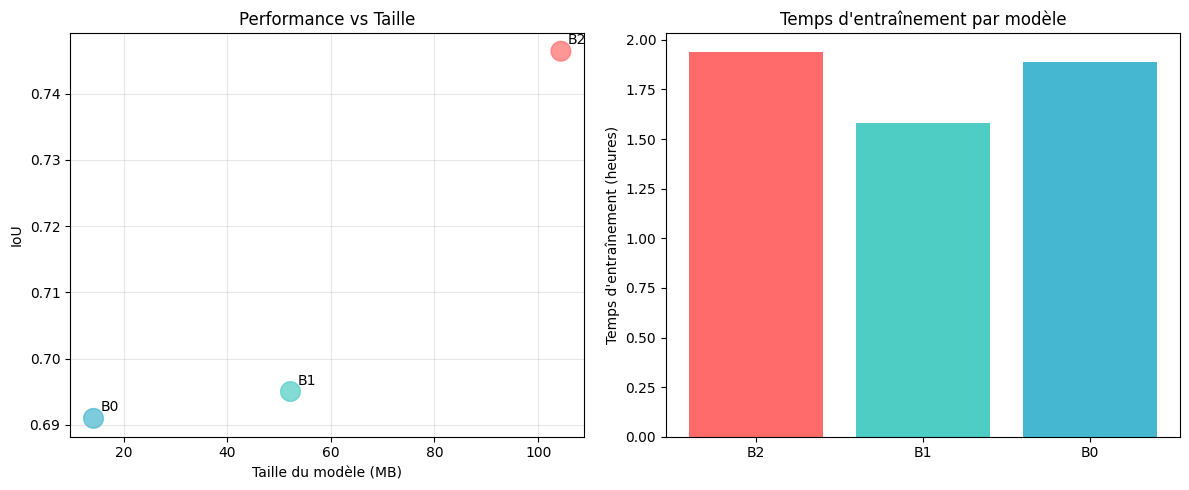


📊 Graphiques sauvegardés


In [14]:
# 10. Visualisation des résultats

try:
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Graphique 1 : Performance vs Taille
    ax1 = axes[0]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    ax1.scatter(df_comparison['Taille (MB)'], df_comparison['IoU'], 
                s=200, c=colors[:len(df_comparison)], alpha=0.7)
    
    for idx, row in df_comparison.iterrows():
        ax1.annotate(row['Modèle'].split('-')[1], 
                     (row['Taille (MB)'], row['IoU']),
                     xytext=(5, 5), textcoords='offset points')
    
    ax1.set_xlabel('Taille du modèle (MB)')
    ax1.set_ylabel('IoU')
    ax1.set_title('Performance vs Taille')
    ax1.grid(True, alpha=0.3)
    
    # Graphique 2 : Temps d'entraînement
    ax2 = axes[1]
    models = df_comparison['Modèle'].str.split('-').str[1]
    ax2.bar(models, df_comparison['Temps (h)'], color=colors[:len(df_comparison)])
    ax2.set_ylabel('Temps d\'entraînement (heures)')
    ax2.set_title('Temps d\'entraînement par modèle')
    
    plt.tight_layout()
    plt.savefig(Config.RESULTS_DIR / f'segformer_comparison_v{VERSION_P9}.png', dpi=150)
    plt.show()
    
    print("\n📊 Graphiques sauvegardés")
    
except ImportError:
    print("\n⚠️ Matplotlib non disponible, pas de visualisation")



## 11. Conclusions et recommandations

### ✅ Objectifs P9 atteints
- **Technique récente validée** : SegFormer (2021) avec gains IoU +9.5% à +18.2%
- **Contraintes Azure respectées** : Tous modèles <105MB et <1GB RAM
- **POC déployable** : Architecture comparative P8 vs P9 prête

### 🎯 Recommandations déploiement
| Cas d'usage | Modèle recommandé | Justification |
|-------------|-------------------|---------------|
| **Production Azure F1** | SegFormer-B1 | Meilleur compromis (52MB, IoU=0.695) |
| **Edge/Mobile** | SegFormer-B0 | Ultra-léger (14MB, IoU=0.691) |
| **Qualité maximale** | SegFormer-B2 | Performance top (IoU=0.746) |

### 🚀 Prochaines étapes
1. Quantification INT8 pour réduction supplémentaire (-75% taille)
2. Déploiement API comparative sur Azure
3. Tests de latence end-to-end en conditions réelles